In [86]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.utils import resample
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [8]:
def bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps):

    z_pred = np.empty((len(z_test), n_boostraps))
    for i in range(n_boostraps):
        data_, z_ = resample(data_train, z_train)
        model.fit(data_,z_)
        z_pred[:,i] = np.squeeze(model.predict(data_test)).T

    error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )

    return error, bias, variance

In [36]:
rseed = 1
num_points = 1000
var = 1
np.random.seed(rseed)

points = np.random.rand(num_points,2)
z = (FrankeFunction(points[:,0], points[:,1]) + np.random.normal(0,var,[1,num_points])).T

In [77]:
n_boostraps = 500
max_deg = 12
model = LinearRegression(fit_intercept=False)
error1 = np.zeros(max_deg)
bias1 = np.zeros(max_deg)
variance1 = np.zeros(max_deg)

# changing the degree of the polynomia
for deg in range(max_deg):

    poly = PolynomialFeatures(degree=deg+1)
    data = poly.fit_transform(points)

    data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

    error1[deg], bias1[deg], variance1[deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

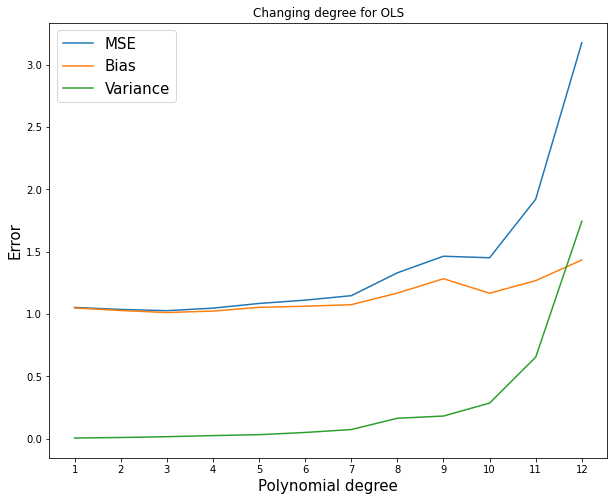

In [79]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,max_deg+1), error1, label='MSE')
plt.plot(range(1,max_deg+1), bias1, label='Bias')
plt.plot(range(1,max_deg+1), variance1, label='Variance')
plt.title("Changing degree for OLS")
plt.xlabel("Polynomial degree", fontsize=15)
plt.xticks(range(1,max_deg+1))
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig('Changing degree for OLS.png')
plt.show()

In [74]:
n_boostraps = 80
deg = 25
lambda_v = np.logspace(-8,1,50)

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error2 = np.zeros(len(lambda_v))
bias2 = np.zeros(len(lambda_v))
variance2 = np.zeros(len(lambda_v))

for i in range(len(lambda_v)):

    lam = lambda_v[i]
    model = Ridge(lam,fit_intercept=False)

    erro2r[i], bias2[i], variance2[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

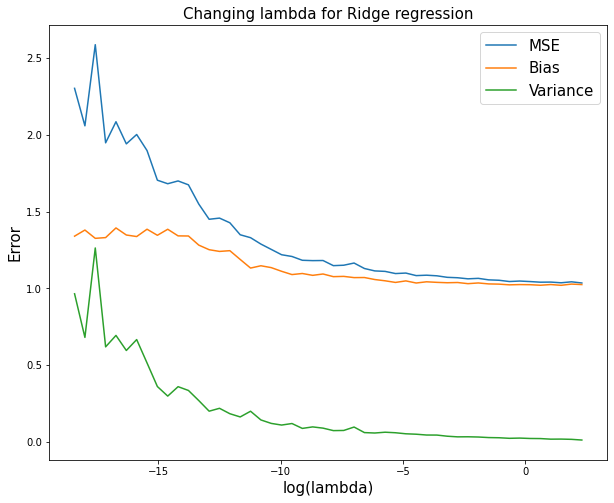

In [76]:
fig = plt.figure(figsize=(10,8))
plt.plot(np.log(lambda_v), error2, label='MSE')
plt.plot(np.log(lambda_v), bias2, label='Bias')
plt.plot(np.log(lambda_v), variance2, label='Variance')
plt.title("Changing lambda for Ridge regression", fontsize=15)
plt.xlabel("log(lambda)", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
#lt.savefig('Changing lambda for Ridge.png')
plt.show()

In [ ]:
n_boostraps = 80
deg = 25
lambda_v = np.logspace(-8,1,50)

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error3 = np.zeros(len(lambda_v))
bias3 = np.zeros(len(lambda_v))
variance3 = np.zeros(len(lambda_v))

for i in range(len(lambda_v)):

    lam = lambda_v[i]
    model = Lasso(lam,fit_intercept=False)

    error3[i], bias3[i], variance3[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

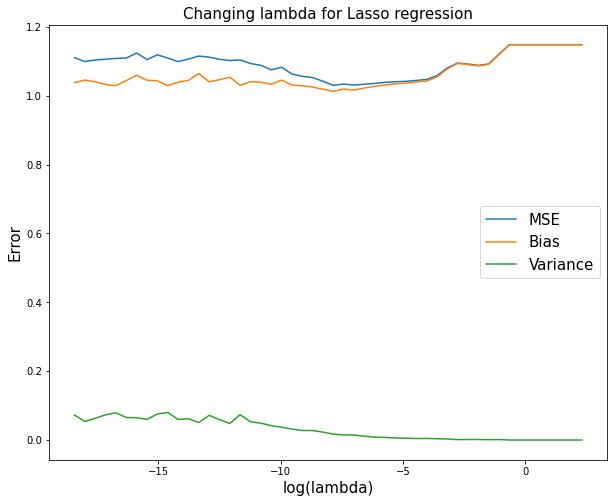

In [81]:
fig = plt.figure(figsize=(10,8))
plt.plot(np.log(lambda_v), error3, label='MSE')
plt.plot(np.log(lambda_v), bias3, label='Bias')
plt.plot(np.log(lambda_v), variance3, label='Variance')
plt.title("Changing lambda for Lasso regression", fontsize=15)
plt.xlabel("log(lambda)", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Changing lambda for Lasso regression.png')
plt.show()

In [90]:
n_boostraps = 20
deg = 12

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2, random_state=rseed)

model = DecisionTreeRegressor()
alphas = model.cost_complexity_pruning_path(data_train,z_train)['ccp_alphas']

error4 = np.zeros(len(alphas))
bias4 = np.zeros(len(alphas))
variance4 = np.zeros(len(alphas))

for i in range(len(alphas)):
    model.ccp_alpha = alphas[i]
    error4[i], bias4[i], variance4[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

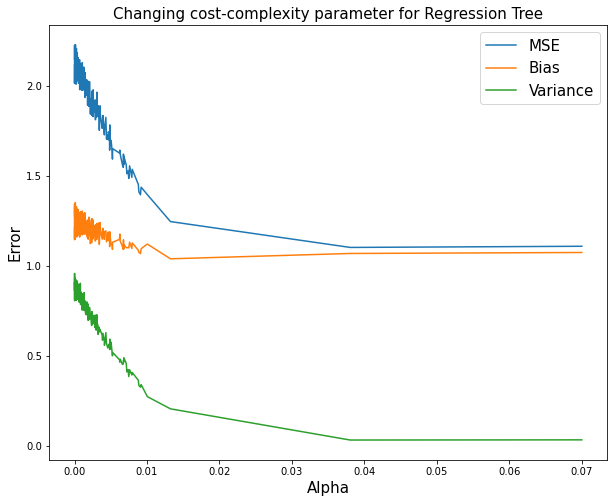

In [92]:
fig = plt.figure(figsize=(10,8))
plt.plot(alphas, error4, label='MSE')
plt.plot(alphas, bias4, label='Bias')
plt.plot(alphas, variance4, label='Variance')
plt.title("Changing cost-complexity parameter for Regression Tree", fontsize=15)
plt.xlabel("Alpha", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Changing cost-complexity parameter for Regression Tree')
plt.show()

In [93]:
n_boostraps = 20
deg = 12
ntree_v = range(1,501,50)

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error5 = np.zeros(len(ntree_v))
bias5 = np.zeros(len(ntree_v))
variance5 = np.zeros(len(ntree_v))

for i in range(len(ntree_v)):

    ntree = ntree_v[i]
    model = RandomForestRegressor(n_estimators=ntree, verbose=False)
    error5[i], bias5[i], variance5[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

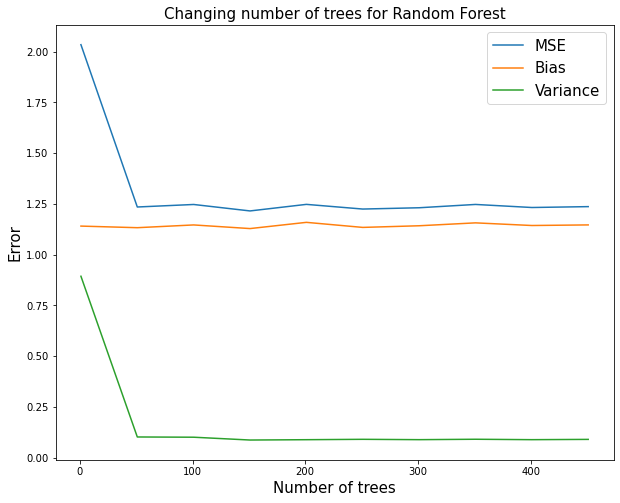

In [95]:
fig = plt.figure(figsize=(10,8))
plt.plot(ntree_v, error5, label='MSE')
plt.plot(ntree_v, bias5, label='Bias')
plt.plot(ntree_v, variance5, label='Variance')
plt.title("Changing number of trees for Random Forest", fontsize=15)
plt.xlabel("Number of trees", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Changing number of trees for Random Forest.png')
plt.show()

In [98]:
n_boostraps = 20
deg = 20
m_v = range(1,9)

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error6 = np.zeros(len(m_v))
bias6 = np.zeros(len(m_v))
variance6 = np.zeros(len(m_v))

for i in range(len(m_v)):

    m = m_v[i]
    model = RandomForestRegressor(max_features=m)
    error6[i], bias6[i], variance6[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

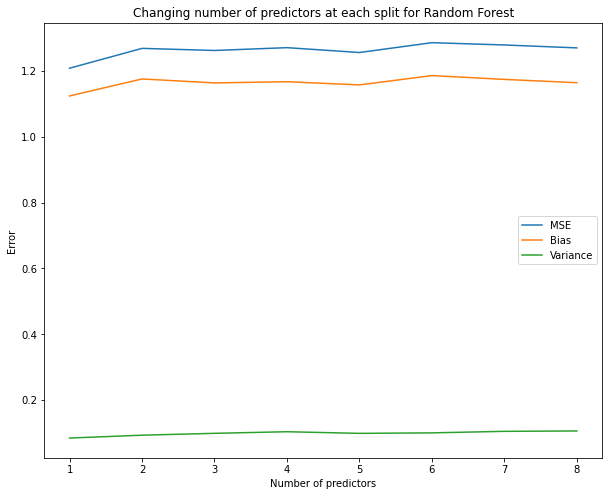

In [99]:
fig = plt.figure(figsize=(10,8))
plt.plot(m_v, error6, label='MSE')
plt.plot(m_v, bias6, label='Bias')
plt.plot(m_v, variance6, label='Variance')
plt.title("Changing number of predictors at each split for Random Forest", fontsize=15)
plt.xlabel("Number of predictors", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Changing number of predictors at each split for Random Forest.png')
plt.show()

In [102]:
n_boostraps = 20
deg = 12
ntree_v = range(1,1001,100)

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error7 = np.zeros(len(ntree_v))
bias7 = np.zeros(len(ntree_v))
variance7 = np.zeros(len(ntree_v))

for i in range(len(ntree_v)):

    ntree = ntree_v[i]
    model = AdaBoostRegressor(n_estimators=ntree)
    error7[i], bias7[i], variance7[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

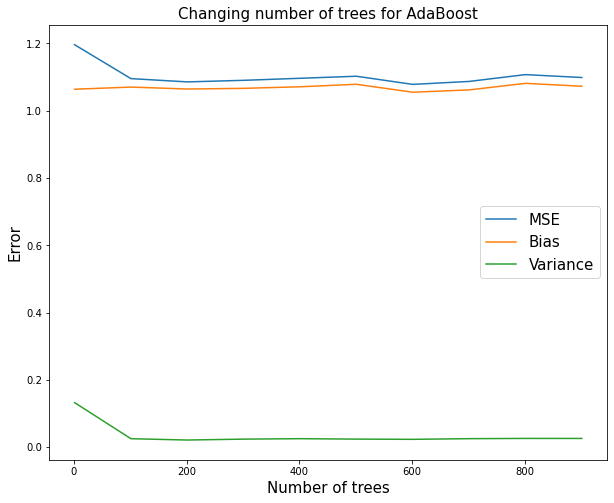

In [103]:
fig = plt.figure(figsize=(10,8))
plt.plot(ntree_v, error7, label='MSE')
plt.plot(ntree_v, bias7, label='Bias')
plt.plot(ntree_v, variance7, label='Variance')
plt.title("Changing number of trees for AdaBoost", fontsize=15)
plt.xlabel("Number of trees", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig('Changing number of trees for AdaBoost.png')
plt.show()

In [111]:
n_boostraps = 20
deg = 12
n_neurons_v = [10,20,30,50,75,100]

poly = PolynomialFeatures(degree=deg+1)
data = poly.fit_transform(points)

data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

error8 = np.zeros(len(n_neurons_v))
bias8 = np.zeros(len(n_neurons_v))
variance8 = np.zeros(len(n_neurons_v))

for i in range(len(n_neurons_v)):
        
        n_neurons = n_neurons_v[i]
        model = MLPRegressor(hidden_layer_sizes=(n_neurons,),learning_rate_init=0.001, max_iter=500)
        error8[i], bias8[i], variance8[i] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

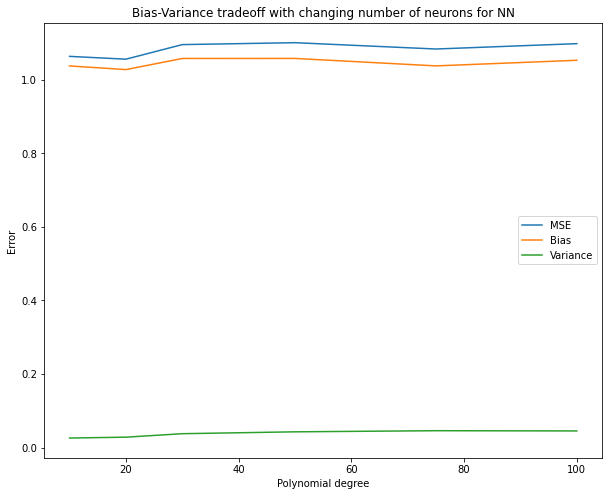

In [112]:
fig = plt.figure(figsize=(10,8))
plt.plot(n_neurons_v, error8, label='MSE')
plt.plot(n_neurons_v, bias8, label='Bias')
plt.plot(n_neurons_v, variance8, label='Variance')
plt.title("Bias-Variance tradeoff with changing number of neurons for NN")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.legend()
plt.savefig('Changing number of neurons for NN.png')
plt.show()